# Make the WOD plot

This notebook creates the classic world ocean database stacked histrogram. It uses csv files of lon, lat and time downloaded with the `download_wod.py` script

In [1]:
import xarray as xr
import pandas as pd
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
combined_file = Path('wod_by_year.csv')
if combined_file.exists():
    df = pd.read_csv(combined_file)
else:
    inputs = Path("downloaded_files").glob("*.csv")
    df = pd.DataFrame()
    for infile in inputs:
        df_sub = pd.read_csv(infile)
        try:
            df_sub["time"] = pd.to_datetime(df_sub["time"])
        except ValueError:
            print(f"fail for {infile}")
            continue
        df = pd.concat([df, df_sub])
    parts = df.ds_name.str.split('_', expand=True)
    df['file_year'] = parts[2]
    df['source'] = parts[1]
    df = df.sort_values('file_year')
    df['year_from_datetime'] = df.time.dt.year
    df = df.dropna(subset='year_from_datetime')
    df['year_from_datetime'] = df['year_from_datetime'].astype(int)
    df.to_csv(combined_file, index=False)

Change the sources here if you want to switch up the order or exclude certain platforms

In [3]:
source_colors = {}
source_clean = {"osd": "Bottle",
                "mbt": "Mechanical BT",
                "xbt": "Expendable BT",
                "ctd": "CTD",
                "pfl": "Argo float",
                "drb": "Drifting buoy",
                "uor": "Undulating CTD",
                "gld": "Glider",
                "mrb": "Moored buoy",
                "apb": "Marine mammal",
}
for i, source in enumerate(source_clean.keys()):
    source_colors[f"{source}: {source_clean[source]}"] = f"C{i}"


In [4]:
years_list = []
for source in source_clean.keys():
    df_sub = df[df.source==source]
    years_list.append(df_sub.year_from_datetime.values)
bins=np.arange(1900, 2025)

Use [matplotlib styles](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html) to spice up the apperance 

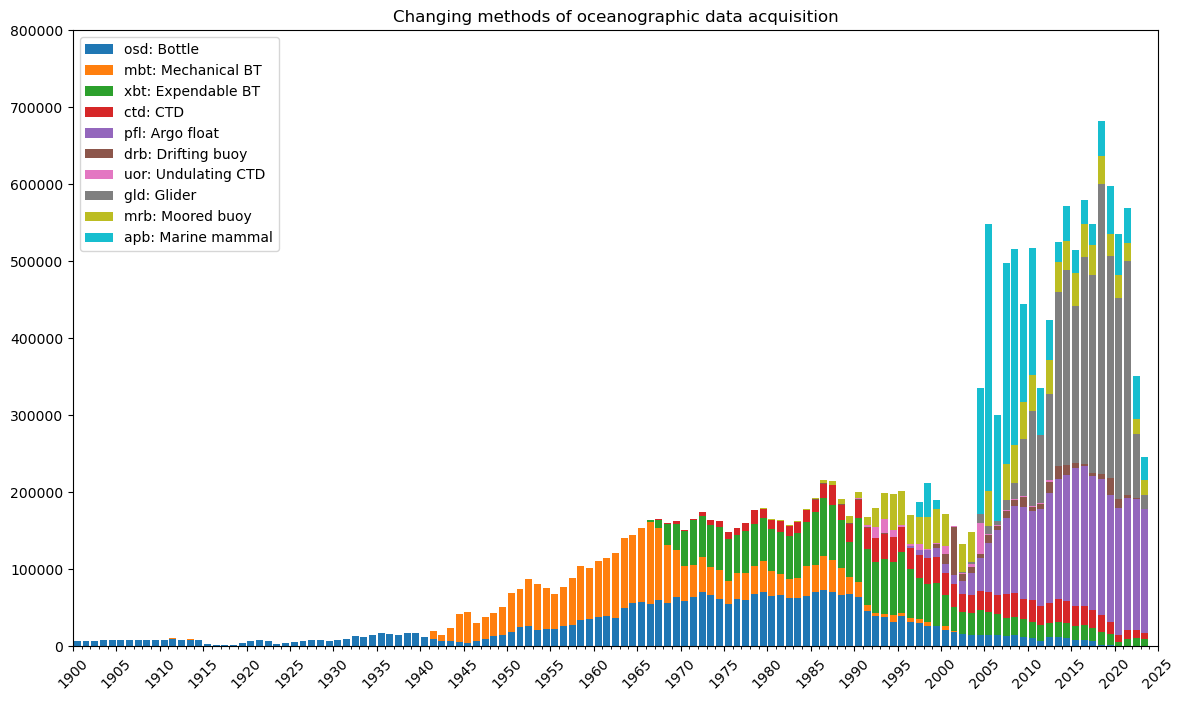

In [5]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.hist(years_list, bins, stacked=True, alpha=1, rwidth=0.8)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="center");
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set(xlim=(1900, 2025), ylim=(0, 800000))
    plt.title("Changing methods of oceanographic data acquisition")
    ax.legend(source_colors)
    plt.savefig("wod-profiles.png")